# WiFi triangulation 

Welcome to the first assignment of CAS 772. In this assignment, you will learn to
- Setup Python development environment
- Install Python package
- Determine the location of a mobile device from RSSI readings and locations of APs given a certain path loss model
- Evaluate the impact of averaging in RSSI
- Visualize the input and output data

## 1. Package ##
Let's first import all the packages that you will need during this assignment. 
- sys, ianus, numpy, warning, matplotlib, scipy

In [1]:
import sys
import ianus
import numpy as np
import warnings
import math

#Uncomment the following line if you run the python code from a terminal
#import matplot
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

from scipy.optimize import minimize
from scipy.spatial import distance

## 2. Read WiFi and ground truth location data ##

- Y is num_loc-by-3 data array with columns being X, Y, Z coordintes
- X_raw is list of size num_loc, each element is an array of size num_AP x num_scan

In [2]:
# Read WiFi Data

datapath = './dataset/'

X_raw, apinfo = ianus.read_wifi_ap_data(datapath+'wifi.pbf', datapath+'itbap.csv')
Y = ianus.read_location_data(datapath + 'location.pbf')
mac_address = list(apinfo.keys())
num_AP = len(mac_address)
num_loc = Y.shape[1] # dimension of columns

assert (num_loc == len(X_raw)) # trigger an error if the codition is 


## 3. Averaging RSSI readings in each location

In [3]:
##### Get the PL0 value and add to the X_mean
PL0 = np.array(list(apinfo.values()))[:,3]

N = 5 #you should vary this to evaluate its impact on the accuracy

X_mean = np.zeros((num_AP, num_loc))
#Suppress the mean of all NaN warning
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Mean of empty slice')
    for i in range(num_loc):
        num_scans = np.minimum(X_raw[i].shape[1], N)
        X_mean[:,i] = np.nanmean(X_raw[i][:,0:num_scans],axis=1) + PL0

### 3.1 Heat map of APs

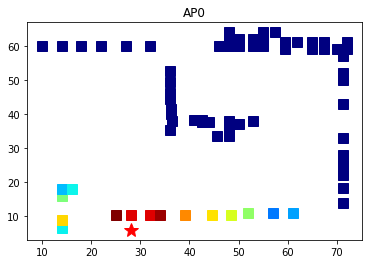

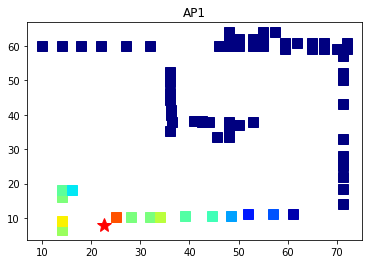

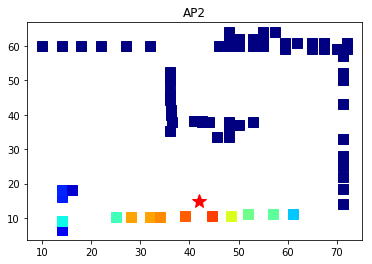

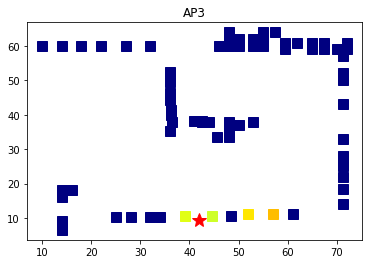

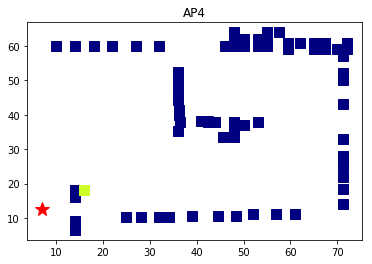

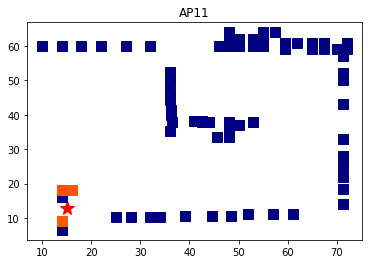

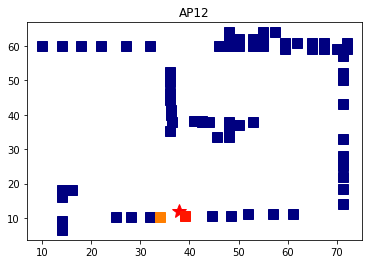

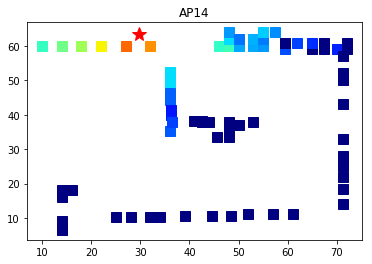

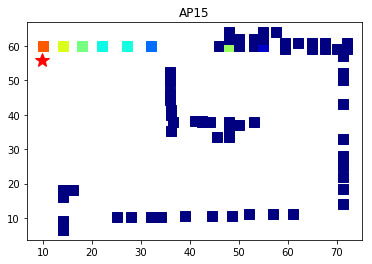

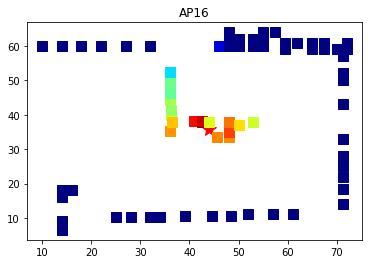

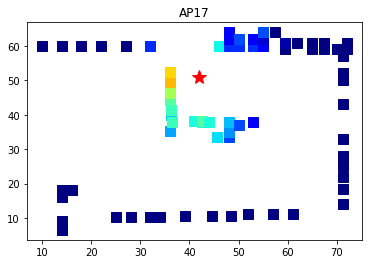

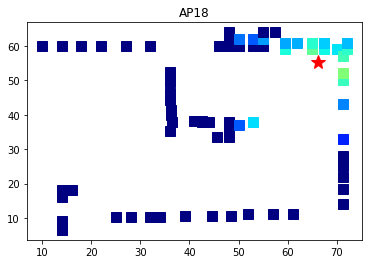

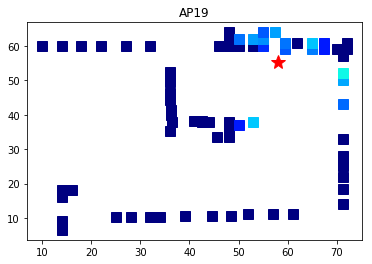

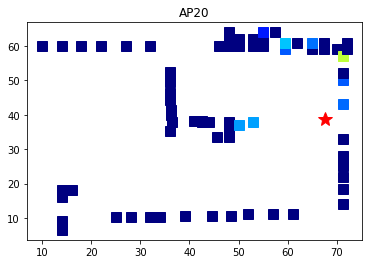

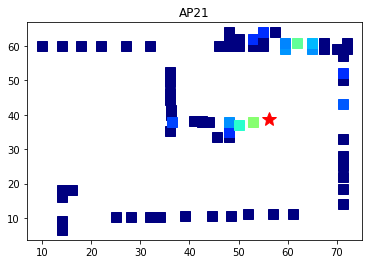

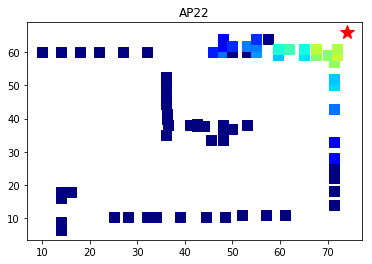

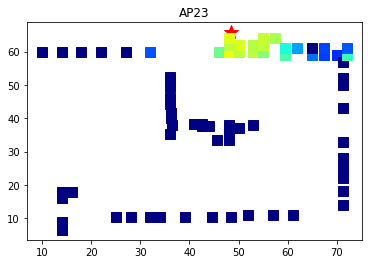

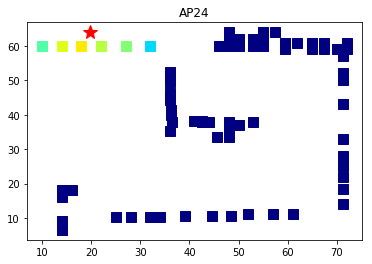

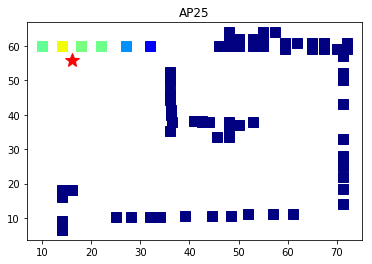

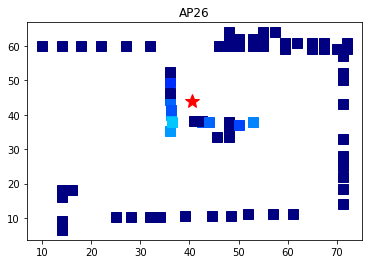

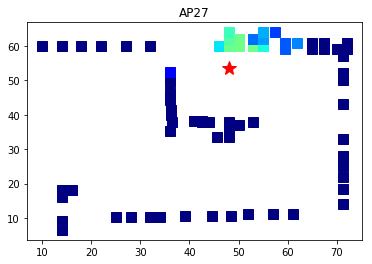

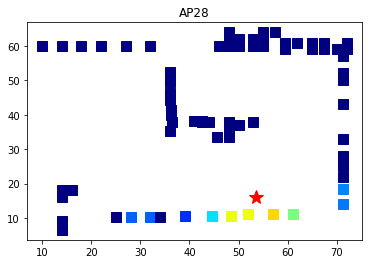

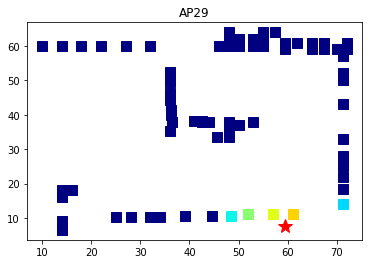

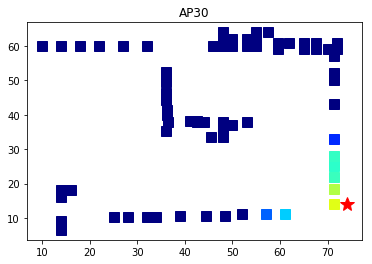

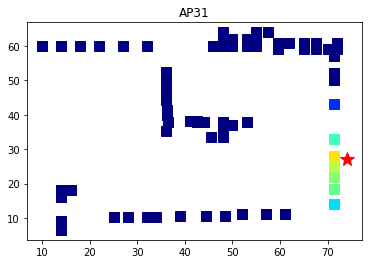

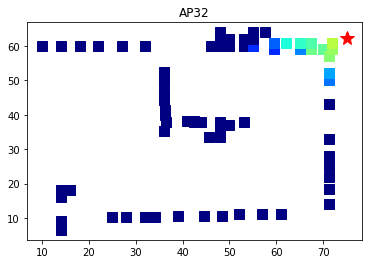

In [4]:
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=np.nanmin(X_mean), vmax=np.nanmax(X_mean))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
plt.close("all")

for ap in range(num_AP):
    if np.sum(np.isnan(X_mean[ap,:])) < X_mean[ap,:].shape:        
        plt.figure()
        plt.title('AP' + str(ap))
        plt.plot(list(apinfo.values())[ap][0], list(apinfo.values())[ap][1], color='r', markersize=15, marker='*')
        for i in range(Y.shape[1]):
            plt.plot(Y[0,i], Y[1,i], color=scalarMap.to_rgba(X_mean[ap, i]), markersize=10, marker='s')
        
        plt.show()

## 4. Trilateration

Use a path-loss model $d \approx 10^{-\frac{P_r[dBm] + PL(d_0) + 40[dBm]}{31.87}}$

### 4.1 Optimization 
The method solves for the location through a (contrained) optimization problem:

$\min_{(x,y,z)}\sum_{i=1}^{i=num\_AP} \left|D(AP_i, (x,y,z)) - d(RSS_i)\right|$

s.t., $x_{min} \le x \le x_{max} \\
y_{min} \le y \le y_{max},\\
z = 1.4$

where $x_{min}, x_{max}, y_{min}, y_{max}$ are boundary conditions, $D(\cdot, \cdot)$ is the Euclidean distance, $d(RSS_i)$ is the distance computed from the path loss model using average RSS with respect to AP $i$. 

*For simplicity, you can assume that the Z coordinate of all locations are known and are all 1.4 meter.*

In [5]:
# # Inferred loctions 
# guessed_loc = np.zeros((3,num_loc))

# #Add your code
# AP = list(apinfo.values()) #read ap location 33*4
# d_rss = 10**(-(X_mean+40)/31.87) #33*71

# def func(x, AP, d_rss):
#     err = 0
#     for ap in range(num_AP):
#         if np.isnan(d_rss[ap,loc]):
#             continue
#         ed = np.sqrt((AP[ap][0]-x[0])**2+(AP[ap][1]-x[1])**2+(AP[ap][2]-x[2])**2)
#         err += abs(ed-d_rss[ap,loc])
#     #ed = np.sqrt((AP[:,0]-x[0])**2+(AP[:,1]-x[1])**2+(AP[:,2]-x[2])**2)
#     #err = np.nansum(abs(ed-d_rss[:,loc]))
#     return err

# x_min = 0
# x_max = max(Y[0])+20
# y_min = 0
# y_max = max(Y[1])+20
# xbound = (x_min, x_max)
# ybound = (y_min, y_max)
# zbound = (1.4, 1.4)
# bds = (xbound, ybound, zbound)

# for loc in range(num_loc):
#     res = minimize(func, [0,0,1.4], args=(AP, d_rss), method = 'L-BFGS-B',bounds = bds, options={'ftol':1e-5, 'maxiter':1e+7}) 
#     guessed_loc[:,loc] = res.x
    
# #print(guessed_loc)

# #Mean and CDF of error
# error = np.sqrt((guessed_loc[0]-Y[0])**2+(guessed_loc[1]-Y[1])**2+(guessed_loc[2]-Y[2])**2)
# mean_error = np.sum(error)/num_loc
# #print(error)
# print('The mean error of localization is', mean_error, 'meters.')

# sorted_ = np.sort(error)
# yvals = np.arange(len(sorted_))/float(len(sorted_))
# plt.plot(sorted_, yvals)
# plt.xlabel('Error (m)')
# plt.ylabel('Cumulative Distribution Probability')
# plt.show()

#### 4.1.1 Impact of optimizer and AP selection (optional)
You may evaluation the performance of different optimizers and the effect of only using a subset of APs. For instance, it is intuitive that faraway APs (namely, those with very low RSSI) may not provide much useful information for localization. 

d_rss_max is 24.0219756792
The mean error of localization is 6.1753315769 meters.


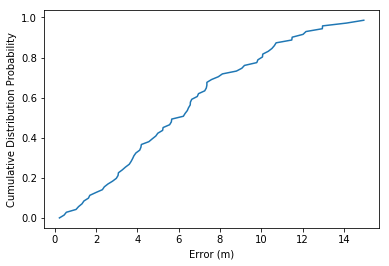

In [6]:
#Inferred loctions 
guessed_loc = np.zeros((3,num_loc))

#Add your code
AP = list(apinfo.values()) #read ap location 33*4
d_rss = 10**(-(X_mean+40)/31.87) #33*71
d_rss_max = np.nanmax(d_rss)
print('d_rss_max is', d_rss_max)

def func(x, AP, d_rss):
    err = 0
    for ap in range(num_AP):
        if np.isnan(d_rss[ap,loc]):
            continue
        elif d_rss[ap,loc]>=d_rss_max-7:
            continue
        ed = np.sqrt((AP[ap][0]-x[0])**2+(AP[ap][1]-x[1])**2+(AP[ap][2]-x[2])**2)
        err += abs(ed-d_rss[ap,loc])
    return err

x_min = 0
x_max = max(Y[0])+20
y_min = 0
y_max = max(Y[1])+20
xbound = (x_min, x_max)
ybound = (y_min, y_max)
zbound = (1.4, 1.4)
bds = (xbound, ybound, zbound)

for loc in range(num_loc):
    res = minimize(func, [0,0,1.4], args=(AP, d_rss), method = 'L-BFGS-B',bounds = bds, options={'ftol':1e-5, 'maxiter':1e+7})
    #res = minimize(func, [0,0,1.4], args=(AP, d_rss), method = 'nelder-mead',bounds = bds, options={'ftol':1e-5, 'maxiter':1e+7}) 
    #res = minimize(func, [0,0,1.4], args=(AP, d_rss), method = 'SLSQP',bounds = bds, options={'ftol':1e-5, 'maxiter':1e+7})
    guessed_loc[:,loc] = res.x
    
#print(guessed_loc)

#Mean and CDF of error
error = np.sqrt((guessed_loc[0]-Y[0])**2+(guessed_loc[1]-Y[1])**2+(guessed_loc[2]-Y[2])**2)
mean_error = np.sum(error)/num_loc
#print(error)
print('The mean error of localization is', mean_error, 'meters.')

sorted_ = np.sort(error)
yvals = np.arange(len(sorted_))/float(len(sorted_))
plt.plot(sorted_, yvals)
plt.xlabel('Error (m)')
plt.ylabel('Cumulative Distribution Probability')
plt.show()

### 4.2 Visualization data

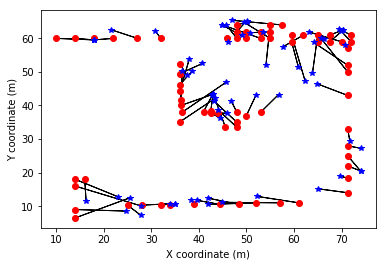

In [7]:
plt.plot(Y[0,:], Y[1,:], 'ro')
plt.plot(guessed_loc[0,:], guessed_loc[1,:], 'b*')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')
for i in range(Y.shape[1]):
    plt.arrow(Y[0,i], Y[1,i], guessed_loc[0,i]-Y[0,i], guessed_loc[1,i]-Y[1,i])

plt.show()

## 5. Weighted centroid approach (optional)
Instead of using the path loss model explicity, a different approach is to find weighted centroid of AP locations, where the **normalized** weight of an AP is a function of the mean RSSI from the AP.

The mean error of localization is 4.90075580543 meters.


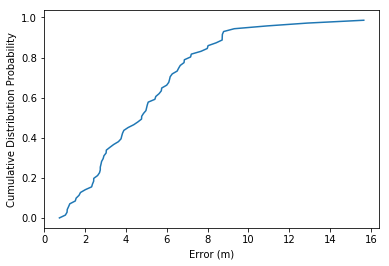

In [8]:
w = 1/d_rss #wij: weight for ith AP to jth location, 33*71
for loc in range(num_loc):
    p = [0,0,0]
    reg =0
    for ap in range(num_AP):
        if np.isnan(w[ap,loc]):
            continue
        elif d_rss[ap,loc]>=d_rss_max-7:
            continue
        p[0] += w[ap,loc]*AP[ap][0]
        p[1] += w[ap,loc]*AP[ap][1]
        p[2] += w[ap,loc]*AP[ap][2] 
        reg += w[ap,loc]
    guessed_loc[:,loc] = p/reg

#Mean and CDF of error
error = np.sqrt((guessed_loc[0]-Y[0])**2+(guessed_loc[1]-Y[1])**2)
mean_error = np.sum(error)/num_loc
#print(error)
print('The mean error of localization is', mean_error, 'meters.')

sorted_ = np.sort(error)
yvals = np.arange(len(sorted_))/float(len(sorted_))
plt.plot(sorted_, yvals)
plt.xlabel('Error (m)')
plt.ylabel('Cumulative Distribution Probability')
plt.show()

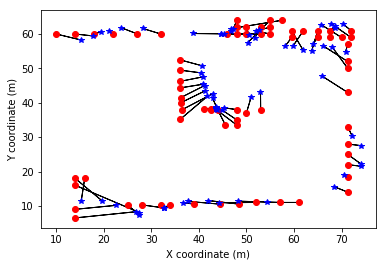

In [9]:
plt.plot(Y[0,:], Y[1,:], 'ro')
plt.plot(guessed_loc[0,:], guessed_loc[1,:], 'b*')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')
for i in range(Y.shape[1]):
    plt.arrow(Y[0,i], Y[1,i], guessed_loc[0,i]-Y[0,i], guessed_loc[1,i]-Y[1,i])

plt.show()